<a href="https://colab.research.google.com/github/vicmcl/e-commerce/blob/models/notebook_essais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from pathlib import Path
from google.colab import drive

content_path = Path('/').absolute() / 'content'
drive_path = content_path / 'drive'
drive.flush_and_unmount()
drive.mount(str(drive_path))

Mounted at /content/drive


In [58]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle

from itertools import product
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples

%matplotlib inline
sns.set_style('ticks')

In [6]:
# Load the dataset from the JSON file directly into a DataFrame
drive_project_dir = drive_path / 'MyDrive'/ 'OCR' / '4_Olist'
df = pd.read_json(drive_project_dir / 'data.json')
features = df[df.columns.tolist()]

# K-Means

In [11]:
models = dict() # Dict to keep track of all the models
inertia = []    # Dict to keep track of all the inertia of the models

# Try K values from 1 to 10
for i in range(1, 11):
    kmeans_model = KMeans(n_clusters=i, random_state=42)

    # Associate each data point with a cluster
    df[f'kmeans_{i}_cluster'] = kmeans_model.fit_predict(features)

    # Store model params
    inertia.append(kmeans_model.inertia_)
    models[i] = kmeans_model

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

## Elbow plot

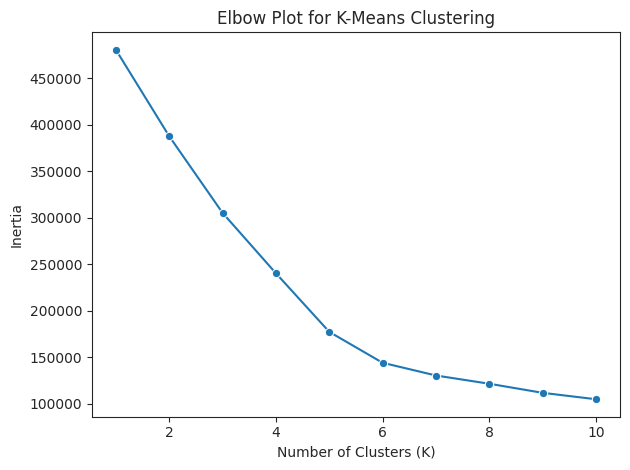

In [36]:
# Choose the K value from the "elbow" in the plot
sns.lineplot(x=range(1, 11), y=inertia, marker='o')
plt.title('Elbow Plot for K-Means Clustering')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.tight_layout()

# Silhouette score and plot

In [23]:
# The value of 5 clusters is chosen
k = 5

# Calculate the average silhouette score
silhouette_avg = silhouette_score(features, df[f'kmeans_{k}_cluster'])

In [25]:
print(f"Average silhouette score for K-Means with {k:} clusters: {silhouette_avg:.5f}")

Average silhouette score for K-Means with 5 clusters: 0.31766


In [70]:
def silhouette_plot(clst, silhouette_vals, avg):
    """
    Plot silhouette values for each cluster.

    Parameters:
    - clst (numpy.ndarray):             Array of cluster labels assigned to each data point.
    - silhouette_vals (numpy.ndarray):  Array of silhouette values for each data point.

    Returns:
    None
    """

    x_lower = 0
    x_tick_positions = []

    for i in range(5):
        # Sort the clusters by their label
        silhouette_cluster_i = silhouette_vals[clst == i]
        silhouette_cluster_i.sort()

        # Get the size of each cluster
        size_cluster_i = silhouette_cluster_i.shape[0]
        x_upper = x_lower + size_cluster_i

        # Fil the plot with plain color
        plt.fill_between(np.arange(x_lower, x_upper),
                          0, silhouette_cluster_i,
                          edgecolor="white", linewidth=2, )

        # Add the cluster labels
        x_tick_labels = range(clst.nunique())
        #plt.text(-0.1, y_lower + 0.5 * size_cluster_i, "Cluster " + str(i))
        x_tick_positions.append(x_lower + size_cluster_i / 2)
        x_lower = x_upper

    plt.xlabel("Cluster label")
    plt.ylabel("Silhouette coefficient values")

    # Indicate the average silhouette score indicated with a dashed line
    plt.axhline(y=avg, color="red", linestyle="--")
    plt.xticks(x_tick_positions, x_tick_labels)

    plt.tight_layout()

In [19]:
sample_silhouette_values = silhouette_samples(features, df[f'kmeans_{k}_cluster'])

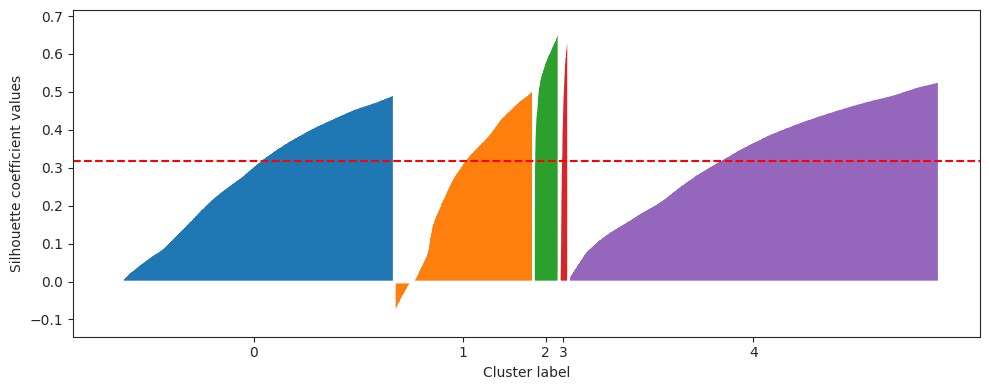

In [71]:
fig = plt.figure(figsize=(10, 4))

silhouette_plot(df[f'kmeans_{k}_cluster'], sample_silhouette_values, silhouette_avg)

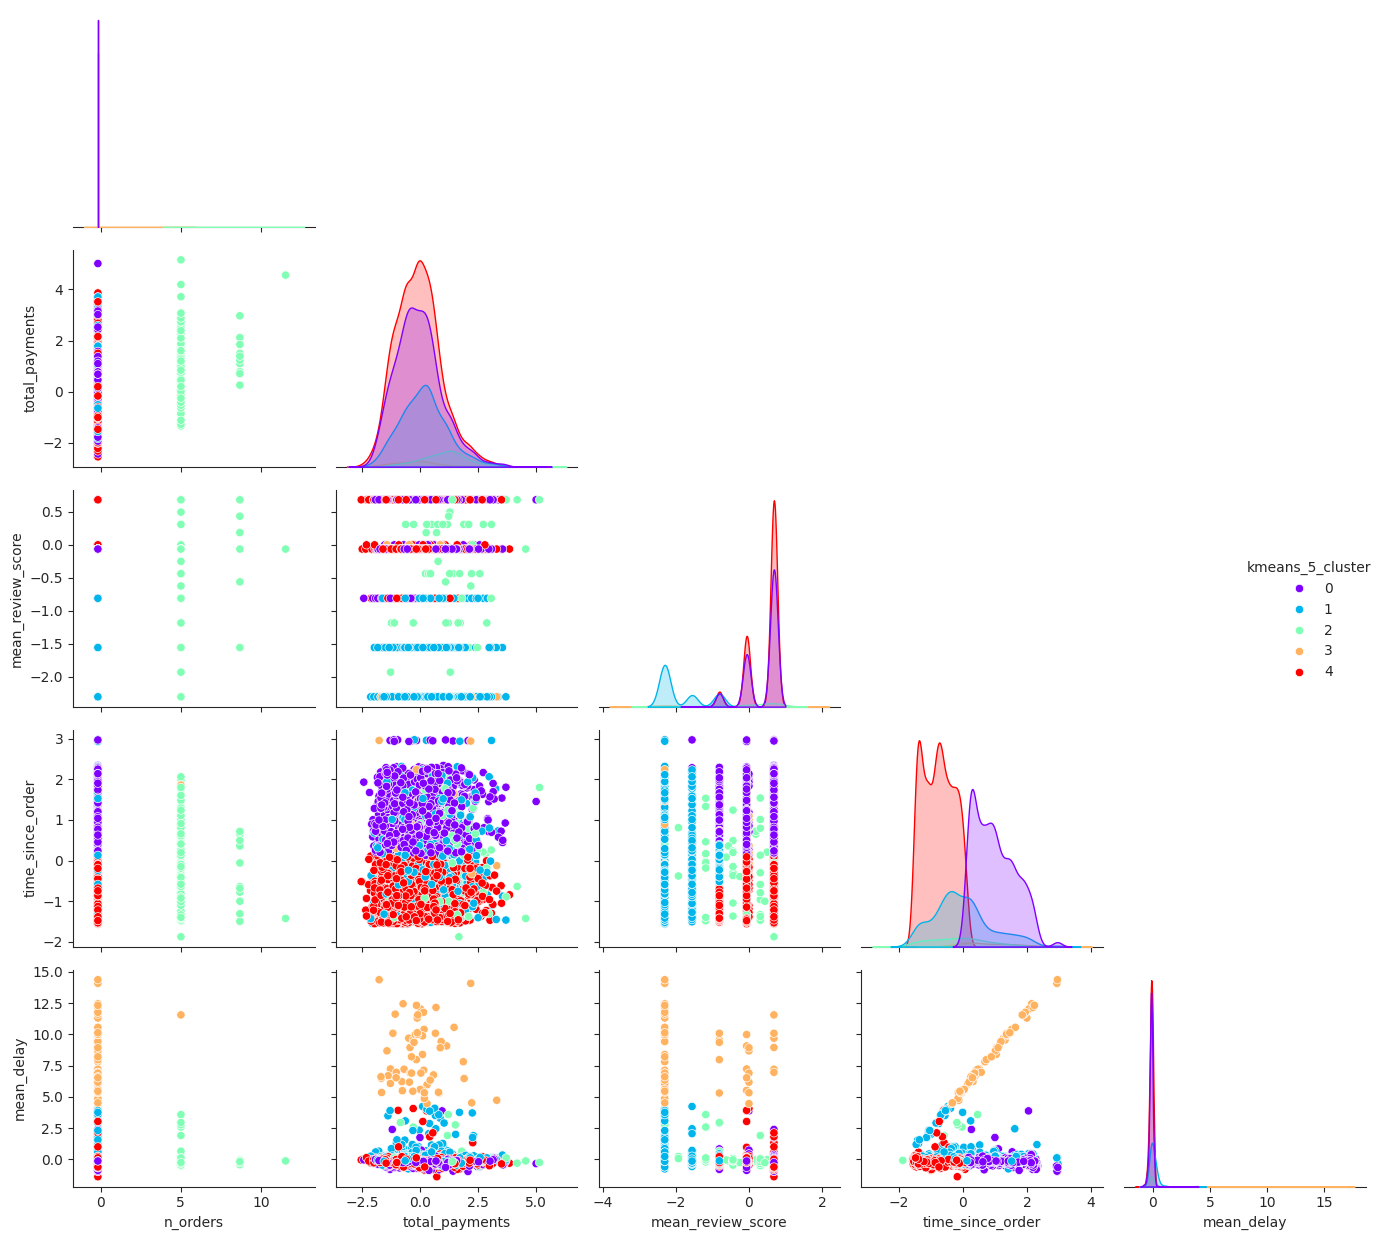

In [72]:
cols = df.columns.tolist()[:len(features.columns)] + [f'kmeans_{k}_cluster']
sns.pairplot(
    df[cols].sample(5000),
    hue=f'kmeans_{k}_cluster',
    palette='rainbow',
    corner=True
)

plt.tight_layout()

# Cluster 0: past clients, satisfied, no delay
# Cluster 1: clients dissatisfied with some delay
# Cluster 2: clients with multiple orders
# Cluster 3: clients dissatisfied with lost orders and long delay
# Cluster 4: recent clients, satisfied, no delay

In [ ]:
with open(drive_project_dir / f'k_means_{k}.pkl', 'wb') as f:
    pickle.dump(models[k], f)

# DBSCAN

In [74]:
# DBSCAN clustering
param_grid = {
    'eps': [0.25, 0.5, 0.75, 1.0],
    'min_samples': [5, 10, 15, 20]
}

models_dbscan = dict()  # Dict to keep track of all the DBSCAN models
scores = dict()         # Dict to keep track of all the silhouette scores

for (eps, min_samples) in list(product(param_grid['eps'], param_grid['min_samples'])):
    # Initialize the DBSCAN model with the current set of params
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)

    # Create the clusters and calculate the corresponding silhouette score
    df[f'dbscan_eps_{eps}_ms_{min_samples}'] = dbscan.fit_predict(features)
    score = silhouette_score(features, df[f'dbscan_eps_{eps}_ms_{min_samples}'])

    scores[(eps, min_samples)] = score
    models_dbscan[(eps, min_samples)] = dbscan

In [75]:
with open("dbscan_models.pkl", "wb") as f:
    pickle.dump(models_dbscan, f)

with open("dbscan_scores.pkl", "wb") as f:
    pickle.dump(scores, f)

In [76]:
scores_df = pd.DataFrame(
    index=sorted(list(set(key[0] for key in scores.keys())), reverse=True),
    columns=sorted(list(set(key[1] for key in scores.keys())))
)

for key, value in scores.items():
    a, b = key
    scores_df.at[a, b] = value

scores_df = scores_df.astype(float)

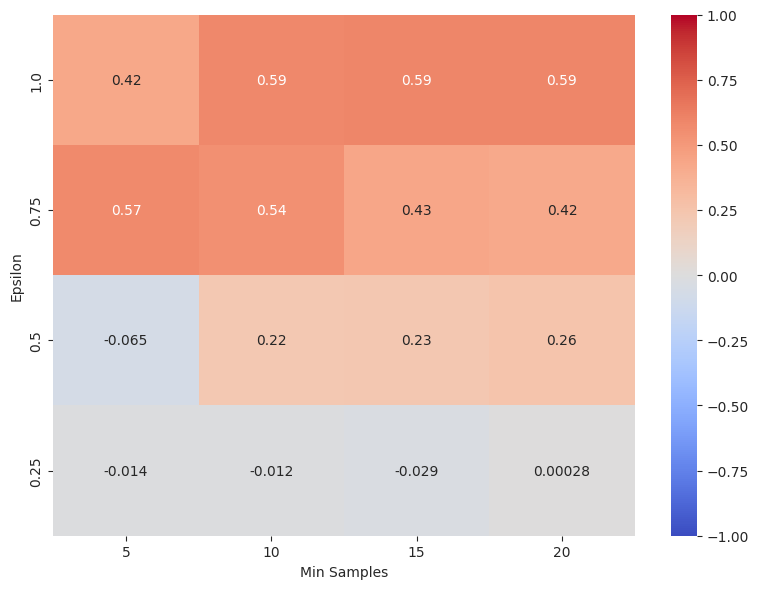

In [77]:
fig = plt.figure(figsize=(8, 6))
sns.heatmap(scores_df, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.xlabel('Min Samples')
plt.ylabel('Epsilon')
plt.tight_layout()

In [78]:
eps = 1.0
min_samples = 10
df[f'dbscan_eps_{eps}_ms_{min_samples}'].value_counts()

 0    93010
 1     2660
-1      208
 2      175
 3       23
 4       20
Name: dbscan_eps_1.0_ms_10, dtype: int64